In [38]:
import datetime
import itertools
import os
import time

import alphashape
import argparse
# import cartopy.crs as ccrs
import cv2
import hdbscan
import igraph as ig
from matplotlib.path import Path
import matplotlib.pyplot as plt
import metis
import networkx as nx
import numpy as np
import scipy


import pickle
import warnings

from concavehull import concavehull
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches
from matplotlib.widgets import CheckButtons, Button, Slider, LassoSelector, RadioButtons, TextBox, RectangleSelector
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from skimage import filters
from sklearn.ensemble import RandomForestClassifier

from hulls import ConcaveHull

import geometry, segmentation as seg, grapher


warnings.simplefilter("ignore")

In [2]:
indir = 'unsegmented'
img_0 = np.asarray(plt.imread(f'{indir}/000.tif'))

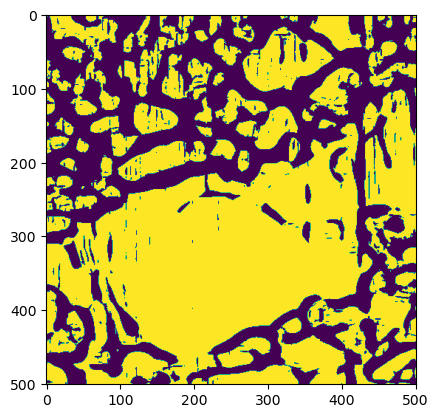

In [3]:
img_01 = seg.neighborhood_average(img_0, d=(5, 5))
fig, ax = plt.subplots()
ax.imshow(filters.meijering(img_01) < 0.1)

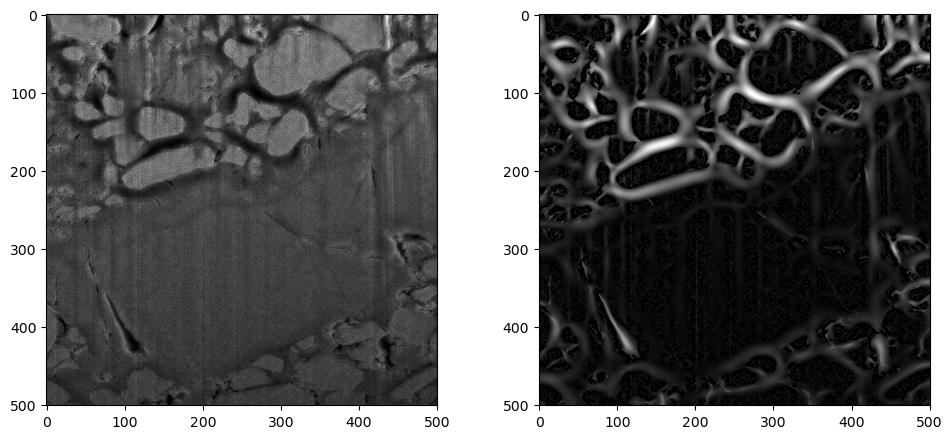

In [5]:
img_1 = filters.meijering(img_01)
# img_2 = filters.meijering(filters.gaussian(img_1 < 0.05, sigma=5))
img_trial = img_0 * (1 - img_1 / np.max(img_1))
img_trial_edges = filters.meijering(img_trial)
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_trial, cmap='gray')
ax[1].imshow(img_trial_edges, cmap='gray')
plt.tight_layout()
plt.show()

### Obtain Clusters

In [89]:
features = seg.build_features_matrix(img_trial_edges > 0.05,img_trial, 0.05)

In [90]:
clusters_0 = seg.get_clustering_results(features[:, :3], **seg.hdbscan_kwargs)

In [91]:
clusters = -1 * np.ones(img_0.shape, dtype=np.int32)

In [92]:
for i in range(features.shape[0]):
    x, y = [int(v) for v in features[i, :2]]
    clusters[x, y] = clusters_0[i]

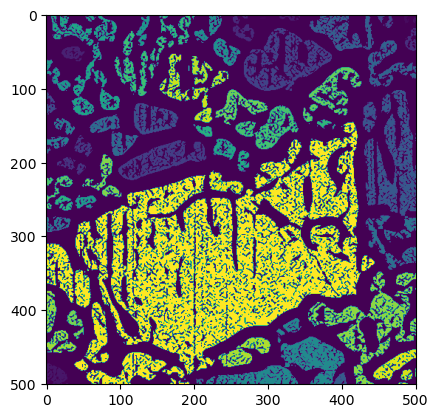

In [93]:
# clusters = seg.enhance_clusters(clusters)
fig, ax = plt.subplots()
ax.imshow(clusters)

### Obtain Polygons Bounding Clusters

0 : 0.00016 : 3
1 : 0.000216 : 2
2 : 0.000112 : 2
3 : 0.00188 : 2
4 : 0.000484 : 4
5 : 0.00136 : 2
6 : 0.00016 : 1
7 : 0.001496 : 2
8 : 0.00084 : 3
9 : 0.001096 : 6
10 : 0.001064 : 5
11 : 0.008552 : 6
12 : 0.013536 : 19
13 : 0.000628 : 4
14 : 0.000708 : 2
15 : 0.004512 : 5
16 : 0.001708 : 2
17 : 0.01914 : 22
18 : 0.000648 : 1
19 : 0.006316 : 11
20 : 0.004576 : 12
21 : 0.000108 : 2
22 : 0.004112 : 7
23 : 0.003884 : 13
24 : 0.001728 : 6
25 : 0.00016 : 1
26 : 0.001236 : 6
27 : 0.000936 : 2
28 : 0.000952 : 4
29 : 0.00126 : 8
30 : 0.016732 : 6
31 : 0.00168 : 5
32 : 0.0022 : 1
33 : 0.001596 : 4
34 : 0.001164 : 3
35 : 0.00108 : 4
36 : 0.000276 : 4
37 : 0.010952 : 17
38 : 0.001676 : 3
39 : 0.000968 : 1
40 : 0.000824 : 2
41 : 0.000928 : 3
42 : 0.000464 : 4
43 : 0.002216 : 6
44 : 0.005952 : 14
45 : 0.006672 : 3
46 : 0.000268 : 1
47 : 0.001276 : 3
48 : 0.000484 : 2
49 : 0.005424 : 8
50 : 0.003976 : 1
51 : 0.001268 : 3
52 : 0.002712 : 6
53 : 0.019176 : 29
54 : 0.001864 : 4
55 : 0.002108 : 6
56 : 0

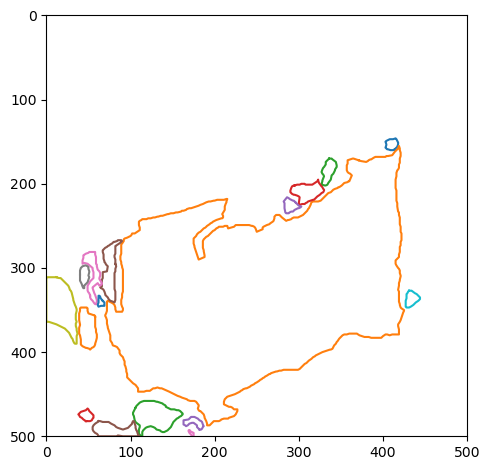

In [96]:
fig, ax = plt.subplots()
for v in np.unique(clusters):
    if v < 0:
        continue
    coords = np.where(np.isclose(clusters, v))
    if coords[0].shape[0] < 25:
            continue
    size = coords[0].shape[0]/500**2
    if size <= 0:
        continue
    arr = []
    for idx in range(coords[0].shape[0]):
        c = (coords[1][idx], coords[0][idx])
        arr.append(c)
    points = {}
    points_view = {}
    for i in range(len(arr)):
        points_view[int(i)] = arr[i]
        points[arr[i]] = int(i)
    graph = grapher.PixelGraph(points=points_view)
    graph.build_graph()
    graph.get_graph_pieces()
    print(int(v), ":", size, ":", graph.n_pieces)
    if size < 0.05:
        try:
            alpha_shape = alphashape.alphashape(arr, 0.25)
            exterior = alpha_shape.exterior
            for c in exterior.coords:
                hull.append((c[0], c[1]))
        except scipy.spatial._qhull.QhullError as e1:
            pass
        except AttributeError as e2:
            pass
        if len(hull) == 0:
            print("empty")
            continue
#         hull_arr = np.array(hull)
#         ax.plot(hull_arr[:, 0], hull_arr[:, 1], label=str(int(v)))
    else:
        for p in graph.pieces:
            hull = []
            if len(p) < 25:
                continue
            arr2 = []
            for c in p:
                arr2.append(points_view[c])
            try:
                alpha_shape = alphashape.alphashape(arr2, 0.25)
                exterior = alpha_shape.exterior
                for c in exterior.coords:
                    hull.append((c[0], c[1]))
            except scipy.spatial._qhull.QhullError as e1:
                pass
            except AttributeError as e2:
                pass
            if len(hull) == 0:
                print("empty")
                continue
            hull_arr = np.array(hull)
            ax.plot(hull_arr[:, 0], hull_arr[:, 1])
# ax.legend()
ax.set_aspect(1)
ax.set_xlim([0, 500])
ax.set_ylim([0, 500])
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [97]:
# fig, ax = plt.subplots()

# new_clusters = -1 * np.ones(clusters.shape, dtype=np.int32)
# adder = 0
# max_v = np.max(clusters)
# for v in np.unique(clusters):
#     print(f"*******************{v}*******************")
#     if v < 0:
#         continue

#     coords = np.where(np.isclose(clusters, v))
#     points = [(coords[0][i], coords[1][i]) for i in range(coords[0].shape[0])]
#     points_arr = np.array(points).reshape(-1, 2)
#     points_dict = {}
#     for i in range(coords[0].shape[0]):
#         points_dict[int(i)] = (int(coords[0][i]), int(coords[1][i]))

#     PG = seg.PixelGraph(points=points_dict)
#     PG.build_graph()
#     PG.get_graph_pieces()
#     pieces = PG.pieces
#     pieces_extended = pieces.copy()
#     n_pieces = PG.n_pieces
#     if np.isclose(PG.n_pieces, 1):
#         new_clusters[coords] = int(v)
#     else:
#         for i, p in enumerate(pieces):
#             p_points = [points_dict[idx] for idx in p]
#             p_points_arr = np.array(p_points).reshape(-1, 2)

#             if p_points_arr.shape[0] / (500 ** 2) >= 0.05:
#                 new_dict = {}
#                 for k, v in points_dict.items():
#                     if int(k) in p:
#                         new_dict[k] = v

#                 graph = seg.PixelGraph(points=new_dict)
#                 graph.build_graph()
#                 G = graph.graph
#                 edgecuts, parts = metis.part_graph(G.to_networkx(), 3, [0.5, 0.3, 0.2])
#                 new_pieces = [[],[],[]]
#                 for idx, p in enumerate(parts):
#                     new_pieces[int(p)].append(int(idx))
#                 pieces_extended += new_pieces

#         for i, p in enumerate(pieces_extended):
#             p_points = [points_dict[idx] for idx in p]
#             p_points_arr = np.array(p_points).reshape(-1, 2)

#             try:
#                 hull = concavehull(p_points_arr, chi_factor=1e-12)
#                 polygon = [(hull[i, 0], hull[i, 1]) for i in range(hull.shape[0])]
#                 print(hull.shape, new_clusters.shape, inside_points.shape)
#                 inside_points = seg.polygon_contains(polygon)
#                 if i == 0:
#                     new_clusters[np.where(inside_points == True)] = v
# #                     polygon = Polygon(p_points)
#                     ax.plot(hull[:, 0] - 5, hull[:, 1] - 5, 'w--', linewidth=0.5)
#                 else:
#                     adder += 1
#                     for c in p:
#                         new_clusters[points_dict[c]] = max_v + adder
#                         # new_clusters[np.where(inside_points == True)] = max_v + adder
#             except RuntimeError as e:
#                 # continue
#                 # for c in p:
#                 #     new_clusters[points_dict[c]] = -1
#                 print(v, i, len(p), e)

In [ ]:
# fig, ax = plt.subplots()
# ax.imshow(new_clusters)